# How to define a simulation to call FEMM

This tutorial shows the different steps to **compute magnetic flux and electromagnetic torque with FEMM**.   
 
The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Simulation_FEMM.ipynb).

Every electrical machine defined in Pyleecan can be automatically defined in [FEMM](http://www.femm.info/wiki/HomePage) to compute torque, airgap flux and electromotive force. To do so, the tutorial is divided into four parts:  
- defining or loading the machine  
- defining the simulation inputs  
- seting-up and running of the magnetic solver  
- ploting of the magnetic flux for the first time step  

## Defining or loading the machine

Before defining the simulation, one first has to define the machine. For this example we import the Toyota Prius 2004 defined in [this tutorial](https://www.pyleecan.org/tuto_Machine.html).

<IPython.core.display.Javascript object>


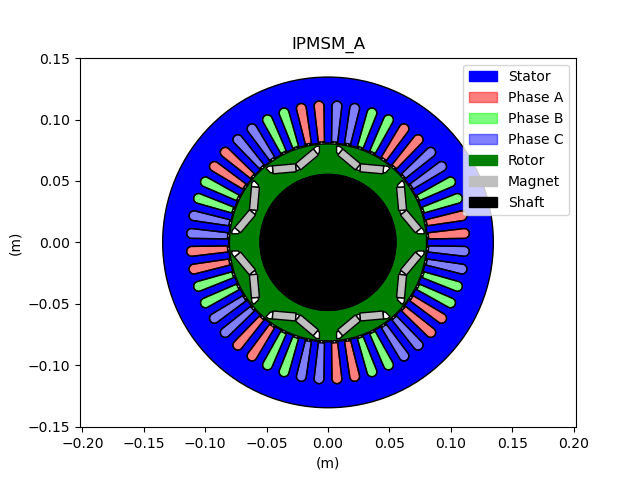

In [2]:
# Add pyleecan to the Python path
import sys
sys.path.append('../..')

from pyleecan.Functions.load import load

# Import the machine from a script
IPMSM_A = load('../Data/Machine/IPMSM_A.json')

# Plot the machine 
%matplotlib notebook
im=IPMSM_A.plot()

## Defining the simulation inputs
### Inputs

To define the simulation, we use [_Simu1_](http://www.pyleecan.org/pyleecan.Classes.Simu1.html) and [_InputCurrent_](http://www.pyleecan.org/pyleecan.Classes.InputCurrent.html) classes. _Simu1_ defines a simulation with 4 physics (electrical, magnetic, structural, acoustic) with weak coupling between each physics. For now, the Magnetic physic is available with the object [_MagFEMM_](https://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) and the Strutural physic is available to compute Maxwell forces only. _InputCurrent_ enables to define the magnetic simulation's inputs such as stator currents, rotor speed, the angular and the time discretization. 

In [3]:
from numpy import ones, pi, array, linspace
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM

rotor_speed = 2000 # [rpm] 

# Create the Simulation
mySimu = Simu1(name="EM_SIPMSM_AL_001", machine=IPMSM_A)   

# Defining Simulation Input
mySimu.input = InputCurrent()

#  Electrical time vector without symmetry [s]
mySimu.input.time.value= linspace(start=0, stop=60/rotor_speed, num=16, endpoint=False)# 16 timesteps

# Angular steps along the airgap circonference for flux density calculation
mySimu.input.angle.value = linspace(start = 0, stop = 2*pi, num=2048, endpoint=False) # 2048 steps 

# Rotor speed as a function of time [rpm]
mySimu.input.Nr.value = ones(16) * rotor_speed

# Stator currents as a function of time, each column correspond to one phase [A]
mySimu.input.Is.value = array(
    [
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 5.01400192e-14, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-3.25143725e-14,  1.53286496e+02, -1.53286496e+02],
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 2.11398201e-13, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-3.90282030e-13,  1.53286496e+02, -1.53286496e+02],
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 9.75431176e-14, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-4.33634526e-13,  1.53286496e+02, -1.53286496e+02],
        [ 1.77000000e+02, -8.85000000e+01, -8.85000000e+01],
        [ 4.55310775e-13, -1.53286496e+02,  1.53286496e+02],
        [-1.77000000e+02,  8.85000000e+01,  8.85000000e+01],
        [-4.76987023e-13,  1.53286496e+02, -1.53286496e+02]
    ]
)


### Configuration
To call FEMM, we need to define the magnetic part of the simulation with [_MagFEMM_](http://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) class. As the simulation will only consider magnetic problem, we set the structural part as None to remove these computations. 

The material parameter and in particular the B(H) curve are setup directly [in the machine](https://www.pyleecan.org/tuto_Machine.html).


In [ ]:
from pyleecan.Classes.MagFEMM import MagFEMM
# Definition of the magnetic simulation (is_mmfr=False => no flux from the magnets)
mySimu.mag = MagFEMM(
    is_stator_linear_BH=0, # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    is_rotor_linear_BH=0,  # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    angle_stator=0,  # Angular position shift of the stator
    file_name = "", # Name of the file to save the FEMM model
)

mySimu.struct = None # We only use the magnetic part 

Pyleecan coupling with FEMM enables to define the machine with symmetry and with sliding band to optimize the computation time. Here we will define only 1/8 of the machine (4 symmetry + antiperiodicity):

In [4]:
mySimu.mag.is_symmetry_a=True,   # False to Compute on the complete machine, True to compute according to sym_a and is_antiper_a
mySimu.mag.sym_a = 4, # Number of symmetry for the angle vector
mySimu.mag.is_antiper_a=True, # To add an antiperiodicity to the angle vector

At the end of the simulation, the mesh and the solution can be saved in the Output object with:

In [ ]:
mySimu.mag.is_get_mesh = True, # To get FEA mesh for latter post-procesing
mySimu.mag.is_save_FEA = False, # To save FEA results in a dat file

You can find all the parameters of _MagFEMM_ by looking at [_Magnetics_](http://www.pyleecan.org/pyleecan.Classes.Magnetics.html) and [_MagFEMM_](http://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) classes.

## Run simulation
To run the simulation, we first have to set the [_Output_](http://www.pyleecan.org/pyleecan.Classes.Output.html) to store the results.

In [5]:
from pyleecan.Classes.Output import Output
myResults = Output(simu=mySimu)
mySimu.run()

Once it is done, the results are stored in the magnetic part of the output (i.e. _myResults.mag_ ) and one can call different plots. This object contains:   
- *time*: magnetic time vector without symmetry   
- *angle*: magnetic position vector without symmetry   
- *Br*: radial airgap flux density   
- *Bt*: tangential airgap flux density   
- *Tem*: electromagnetic torque   
- *Tem_av*: average electromagnetic torque   
- *Tem_rip*: torque ripple   
- *Phi_wind_stator*: stator winding flux   
- *emf*: electromotive force  


## Plot results
_Output_ object embbed different plot to visualize results easily. 

For instance, we can plot the radial and tangential magnetic flux in the airgap at a specific timestep:

<IPython.core.display.Javascript object>


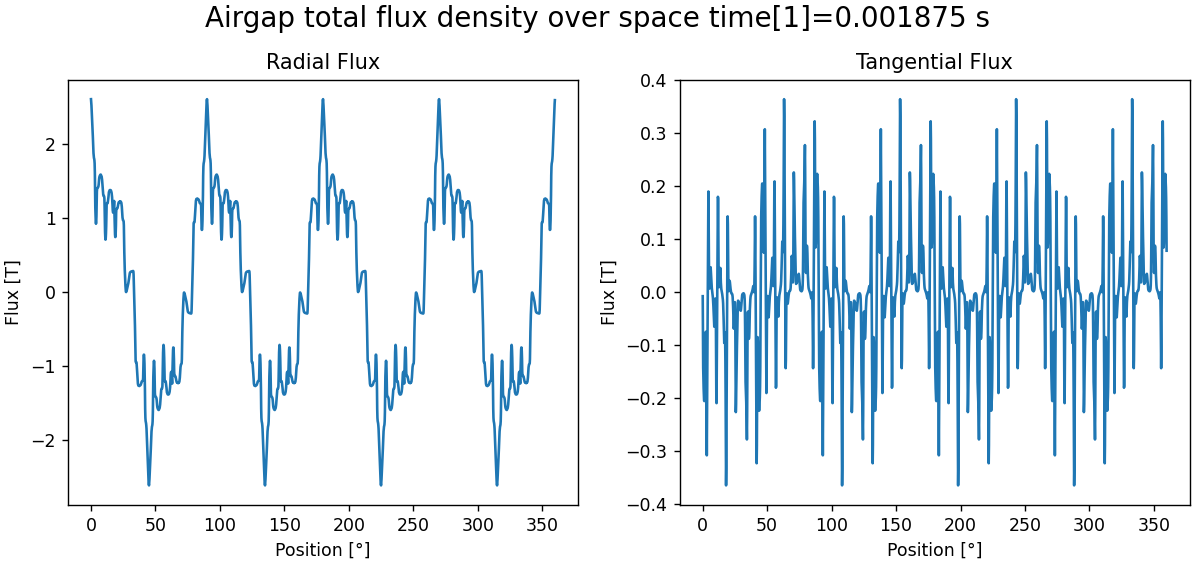

In [5]:
%matplotlib notebook
myResults.plot_B_space(j_t0=1)

If _is\_get\_mesh_ has been set to _True_ in the simulation setup, one can also plot the 2D field amplitude per element at a chosen timestep: 

<IPython.core.display.Javascript object>


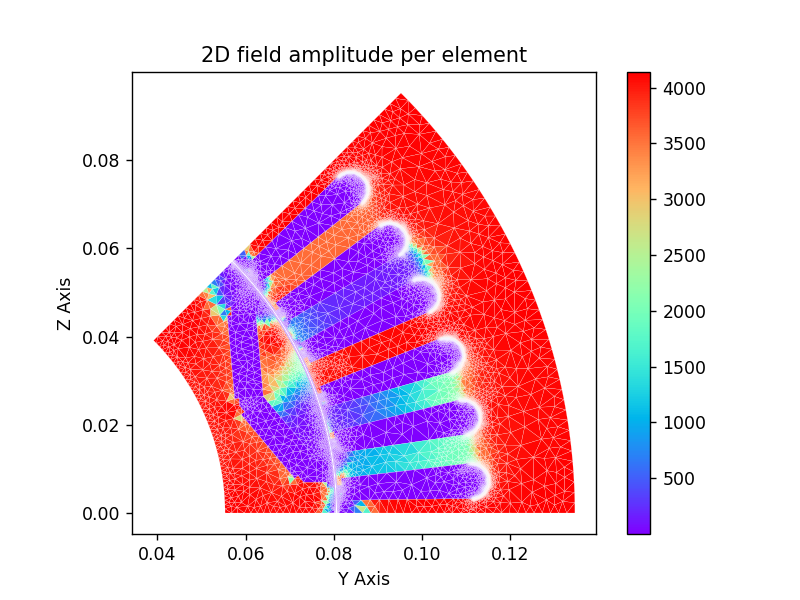

In [6]:
%matplotlib notebook
myResults.plot_mesh_field(myResults.mag.meshsolution, j_t0=0, title ="2D field amplitude per element")

You can also define your own plot:

In [7]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode 
init_notebook_mode() 

x = myResults.mag.angle*180/pi # rad -> °
y = myResults.mag.time
z = myResults.mag.Br
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout( )
fig.update_layout(title='Radial flux density in the airgap over time and angle',
                  autosize=True,
                  scene = dict(
                      xaxis_title='Angle [°]',
                      yaxis_title='Time [s]',
                      zaxis_title='Flux [T]'
                  ),
                  width=700,
                  margin=dict(r=20, b=100, l=10, t=100),
                 )

fig.show(config = {"displaylogo":False})